### Obtención de datos externos

In [1]:
### Número de hipotecas

import requests
import time
import pprint
import pickle
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import xml.etree.ElementTree as ET
import re
from unicodedata import normalize

def troceador_calles_api(street):
    words_street = []
    words_in_street = street.split(' ')
    for word in words_in_street:
        words = word.split(',')
        for w in words:
            if '/' in w:
                words.extend(w.split('/'))
        for w in words:
            if len(w) > 2 and w.upper() != 'DEL':
                words_street.append(w)
    return words_street
          
def comparador(streets_api, street_to_find):
    words_street_to_find = troceador_calles_api(street_to_find)
    streets = []
    for street in streets_api:
        words_street_api = troceador_calles_api(street)
        coincidences = 0
        for w1 in words_street_api:
            w1 = normalizador(w1)
            len_w1 = len(w1)
            coincidences_words = 0
            for w2 in words_street_to_find:
                w2 = normalizador(w2)
                if len_w1-1 < len(w2) < len_w1+1:
                    if w2 in w1:
                        coincidences_words += 1
            coincidences += coincidences_words
        if coincidences == len(words_street_to_find) and coincidences != 0:
            streets.append(street)
        elif coincidences >= max(int((len(words_street_api)+1)/2), int((len(words_street_to_find)+1)/2)):
            streets.append(street)
    
    if len(streets)==1:
        return streets[0]
    else:
        if len(set(streets))==1:
            return streets[0]
        else:
            for street in streets:
                if normalizador(street) in normalizador(street_to_find):
                    return street
            return False
        
def normalizador(string):
    string = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", str(string)), 0, re.I
    )
    string = string.lower()
    return normalize( 'NFC', string)

def parseo_fecha_cuatrimeste(row):
    if row[1] == 'Primero':
        date = '01/01/'
    elif row[1] == 'Segundo':
        date = '01/04/'
    elif row[1] == 'Tercero':
        date = '01/07/'
    elif row[1] == 'Cuarto':
        date = '01/10/'
    return date+str(row[0])

#AL EJECUTAR ESTE SCRIPT ACTUALIZAMOS LAS VIVIENDAS QUE TENEMOS DISPONIBLES PARA EL MODELO
#lA SIGUIENTE TABLA ES LA TABLA FINAL QUE PROVIENE DEL PROYECTO Proyecto_datos_finales de SAS
data_tablin = pd.read_csv(r'C:\Users\Marta\Scripts - Presentación\DATOS_FINAL.csv', 
                   sep=';', engine="python", encoding="latin1")

#DOCUMENTO QUE HEMOS DESCARGADO DEL INE, VER EL LINK DE DESCARGA EN LA DOCUMENTACIÓN
data_ine = pd.read_csv(r'C:\Users\Marta\Scripts - Presentación\Hipotecas_constituidas.csv', 
                   sep=';', engine="python", decimal='.', encoding="latin1")

data_ine = data_ine.iloc[:,:-1]

province_pc = list(data_ine.iloc[:, 0].apply(lambda s: s[:2]))
province_name = list(data_ine.iloc[:, 0].apply(lambda s: s[3:]))
for num_col in range(1, len(data_ine.columns)):
    
    date_year = [data_ine.columns[num_col][:4]]*len(data_ine)
    date_month = [data_ine.columns[num_col][5:]]*len(data_ine)
    value = list(data_ine.iloc[:, num_col])
    
    df_month = pd.DataFrame({'Código provincia':province_pc, 'Provincia':province_name,
                             'Año':date_year, 'Código mes':date_month, 'Hipotecas':value })
    
    if num_col == 1:
        df_ine = df_month
    else:
        df_ine = df_ine.append(df_month)

dict_month = {'01':'Primero', '02':'Primero', '03':'Primero', '04':'Segundo', '05':'Segundo', '06':'Segundo', '07':'Tercero', '08':'Tercero', '09':'Tercero', '10': 'Cuarto', '11':'Cuarto', '12':'Cuarto'} 

df_ine['Cuatrimestre'] = df_ine['Código mes'].map(dict_month)


df_ine['Fecha'] = df_ine.loc[:,['Año', 'Cuatrimestre']].apply(parseo_fecha_cuatrimeste,  axis=1)

col_to_del = ['Año', 'Código mes', 'Cuatrimestre']
for col in col_to_del:
    del df_ine[col]

df_ine.columns= ['CODPROVINC', 'Provincia', 'Hipotecas', 'Fecha']
df_ine= df_ine.replace('01', '1')
df_ine=df_ine.replace('02', '2')
df_ine=df_ine.replace('03', '3')
df_ine=df_ine.replace('04', '4')
df_ine=df_ine.replace('05', '5')
df_ine=df_ine.replace('06', '6')
df_ine=df_ine.replace('07', '7')
df_ine=df_ine.replace('08', '8')
df_ine=df_ine.replace('09', '9')

data_tablin = data_tablin[data_tablin['FCHTASAC'].notnull()]
data_tablin.loc[:,'DIA'] = data_tablin['FCHTASAC'].apply(lambda s: s[:2])
data_tablin.loc[:,'MES'] = data_tablin['FCHTASAC'].apply(lambda s: s[2:5])
data_tablin.loc[:,'AÑO'] = data_tablin['FCHTASAC'].apply(lambda s: int(s[5:9]))
dict_cuatri = {'NOV':'Cuarto', 'SEP':'Tercero', 'OCT':'Cuarto', 'DEC':'Cuarto', 'MAR':'Primero', 'JAN':'Primero', 'MAY':'Segundo', 'FEB':'Primero', 'APR':'Segundo', 'JUN':'Segundo', 'JUL':'Tercero', 'AUG':'Tercero'}
data_tablin['CUATRIMESTRE'] = data_tablin['MES'].map(dict_cuatri)
data_tablin = data_tablin[(data_tablin['AÑO']>1994)&(data_tablin['AÑO']<2019)]

data_tablin['Fecha'] = data_tablin.loc[:,['AÑO', 'CUATRIMESTRE']].apply(parseo_fecha_cuatrimeste,  axis=1)

columns_to_del = ['DIA','MES','AÑO', 'CUATRIMESTRE','FCHTASAC']
for col in columns_to_del:
    del data_tablin[col]

data_tablin["CODPROVINC"] = pd.to_numeric(data_tablin["CODPROVINC"])
df_ine['CODPROVINC'] = pd.to_numeric(df_ine['CODPROVINC'])

data_tablin = data_tablin.merge(df_ine, left_on=['Fecha', 'CODPROVINC'],
                                    right_on=['Fecha', 'CODPROVINC'], how='inner')

### Tasa de desempleo 

data_desempleo_1 = pd.read_csv(r'C:\Users\Marta\Scripts - Presentación\Desempleo-2002-2005.csv', 
                   sep=';', engine="python", decimal=',', encoding="latin1")
data_desempleo_2 = pd.read_csv(r'C:\Users\Marta\Scripts - Presentación\Desempleo-2015-2018.csv', 
                   sep=';', engine="python", decimal=',', encoding="latin1")

col_to_del_1 = list(data_desempleo_1.columns[1:57])
col_to_del_1.extend(list(data_desempleo_1.columns[113:]))
for col in col_to_del_1:
    del data_desempleo_1[col]

col_to_del_2 = list(data_desempleo_2.columns[1:13])
col_to_del_2.extend(list(data_desempleo_2.columns[25:]))
for col in col_to_del_2:
    del data_desempleo_2[col]

data_desempleo_1.columns = data_desempleo_1.iloc[0,:]
data_desempleo_1 = data_desempleo_1.loc[1:]

data_desempleo_2.columns = data_desempleo_2.iloc[0,:]
data_desempleo_2 = data_desempleo_2.loc[1:]

data_desempleo = pd.concat([data_desempleo_2, data_desempleo_1.iloc[:,1:]], axis=1)

data_desempleo = data_desempleo.iloc[1:,:]

data_desempleo.index = range(len(data_desempleo))

data_desempleo = data_desempleo.rename(columns={np.nan: 'Prov'})

data_desempleo[['Prov','Provincia']] = data_desempleo['Prov'].str.split(" ", n = 1, expand = True) 

prov_tablin = list(data_tablin.CODPROVINC.unique())[:-1]
prov_fomento = list(data_desempleo.Prov.unique())

data_desempleo=data_desempleo.drop(['Provincia'], axis=1)

provinces = data_desempleo.Prov
dict_quarter = {'T1':'Primero', 'T2':'Segundo', 'T3':'Tercero', 'T4':'Cuarto'}
for col in data_desempleo.columns[1:]:
    
    year = [col[:4]]*len(data_desempleo)
    quarter = [dict_quarter[col[4:]]]*len(data_desempleo)
    disemploy = data_desempleo.loc[:,col]
    
    if col == '2018T4':
        data_disemploy = pd.DataFrame({'Provincia':provinces, 'Año':year, 'Cuatrimestre':quarter, 'Tasa desempleo':disemploy})
    else:
        data_disemploy = data_disemploy.append(pd.DataFrame({'Provincia':provinces, 'Año':year, 'Cuatrimestre':quarter, 'Tasa desempleo':disemploy}))

data_disemploy['Fecha'] = data_disemploy.loc[:,['Año', 'Cuatrimestre']].apply(parseo_fecha_cuatrimeste,  axis=1)

col_to_del = ['Año', 'Cuatrimestre']
for col in col_to_del:
    del data_disemploy[col]

data_disemploy=data_disemploy.replace('01', '1')
data_disemploy=data_disemploy.replace('02', '2')
data_disemploy=data_disemploy.replace('03', '3')
data_disemploy=data_disemploy.replace('04', '4')
data_disemploy=data_disemploy.replace('05', '5')
data_disemploy=data_disemploy.replace('06', '6')
data_disemploy=data_disemploy.replace('07', '7')
data_disemploy=data_disemploy.replace('08', '8')
data_disemploy=data_disemploy.replace('09', '9')

data_disemploy['Provincia'] = pd.to_numeric(data_disemploy['Provincia'])
data_tablin['CODPROVINC'] = pd.to_numeric(data_tablin['CODPROVINC'])

data_tablin_disemploy = data_tablin.merge(data_disemploy, left_on=['Fecha', 'CODPROVINC'], right_on=['Fecha', 'Provincia'], how='inner')

data_tablin_disemploy= data_tablin_disemploy.drop_duplicates()

data_tablin_disemploy=data_tablin_disemploy.drop(['Provincia_y'], axis=1)

data_tablin_disemploy.to_csv(r'C:\Users\Marta\Scripts - Presentación\tablin_datos_externos.csv', 
                   sep=';', encoding="latin1", decimal=',', index=False)

### Procesamiento de los datos

In [2]:
import requests
import time
import pprint
import pickle
import numpy as np
import json
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import xml.etree.ElementTree as ET
import re
from unicodedata import normalize
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from pandas_summary import DataFrameSummary
%matplotlib
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
import pylab 
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFECV, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA, KernelPCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit, Lasso, LassoLarsIC, ElasticNet, ElasticNetCV
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor, HuberRegressor, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

tablin = pd.read_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos - copia - Marta\tablin_datos_externos.csv', 
                   sep=';', engine="python", decimal=',', encoding="latin1")

fechas = list(tablin.Fecha.drop_duplicates())
dictionary_dates_date_to_num = {}
dictionary_dates_num_to_date = {}
for date_iter in range(len(fechas)):
    dictionary_dates_date_to_num[fechas[date_iter]] = date_iter
    dictionary_dates_num_to_date[date_iter] = fechas[date_iter]

dictionary_dates_num_to_date[56] = '01/01/2019'
dictionary_dates_num_to_date[57] = '01/04/2019'
dictionary_dates_num_to_date[58] = '01/07/2019'
dictionary_dates_num_to_date[59] = '01/10/2019'
dictionary_dates_num_to_date[60] = '01/01/2020'
dictionary_dates_num_to_date[61] = '01/04/2020'
dictionary_dates_num_to_date[62] = '01/07/2020'
dictionary_dates_num_to_date[63] = '01/10/2020'

#PREPROCESSING
#ELIMINATE OUTLIERS
tablin= tablin[np.abs(tablin['Hipotecas']-tablin['Hipotecas'].mean()) <= (3*tablin['Hipotecas'].std())] 

#LOG TRANSFORMATION
tablin['Hipotecas_log'] = np.log(tablin['Hipotecas'])
tablin['Tasa desempleo_log'] = np.log(tablin['Tasa desempleo'])

#ENCODE FECHA TO CREATE A VARIABLE THAT GIVES INFO ABOUT TIMING

tablin['Año'] = pd.to_datetime(tablin['Fecha'])
tablin['Año']= tablin['Año'].dt.year
tablin['Año']= pd.to_numeric(tablin['Año'])

encode =  {2005: 1,2006: 2, 2007: 3,2008: 4, 2009: 5, 2010: 6, 2011: 7,
           2012: 8, 2013: 9,2014: 10,2015: 11, 2016: 12, 2017: 13,2018: 14} 

tablin['Año']= tablin['Año'].replace(encode)

tablin=tablin.dropna()

tablin= tablin.drop_duplicates()

with open(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos - copia - Marta\dict_pc.pickle', 'rb') as file:
    dict_pc = pickle.load(file)
    
with open(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos - copia - Marta\dict_to_replace.pickle', 'rb') as file:
    dict_to_replace = pickle.load(file)    

def parseo_fecha_cuatrimeste(row):
    if row[1] == 'Primero':
        date = '01/01/'
    elif row[1] == 'Segundo':
        date = '01/04/'
    elif row[1] == 'Tercero':
        date = '01/07/'
    elif row[1] == 'Cuarto':
        date = '01/10/'
    return date+str(row[0])

tablin = tablin[tablin['SUPADAPT'] != 0]

## Procesar

tablin = tablin[tablin['SUPADAPT']>1]
tablin['Index'] = tablin.index   

data_pred= tablin
data_pred = data_pred.drop_duplicates()

# Mapear la fecha con números reales para poderlo introducir en el modelo
#Filtrar las viviendas para quedarnos sólo con la última tasación de cada vivienda
dates = {}
iter_ = 0
for year in range(2005,2019):
    for month in ['01','04','07','10']:
        for day in ['01']:
            dates[day+'/'+month+'/'+str(year)] = iter_
            iter_ += 1

data_pred['Fecha_num'] = data_pred['Fecha'].map(dates)

data_pred_index = data_pred.loc[:,['MATRICULA','Fecha_num']].groupby('MATRICULA').idxmax()   #agrupamos por matrícula (la fecha más reciente)

data_pred = data_pred.loc[data_pred_index['Fecha_num']]   #filtramos y nos quedamos sin duplicados de la misma vivienda con distinta fecha 

#Recodificar
data_pred= data_pred.replace('SI', '1')
data_pred= data_pred.replace('NO', '0')
data_pred= data_pred.replace('LIBRE', 'Libre' )
data_pred= data_pred.replace('ESPECIAL', 'Especial')

## Eliminar duplicados y nulos

data_pred = data_pred.drop_duplicates()
data_pred= data_pred.dropna() 

#Procesar EDIF_FECHA_CONSTRUCCION 

data_pred.loc[:,'EDIF_FECHA_CONSTRUCCION'] = data_pred['EDIF_FECHA_CONSTRUCCION'].apply(lambda s: (s[5:9]))
data_pred['EDIF_FECHA_CONSTRUCCION']= data_pred.loc[:,['EDIF_FECHA_CONSTRUCCION']].replace("", np.nan)
data_pred= data_pred.dropna() 

#Convertimos la fecha de construccion a una variable de antigüedad de la vivienda
data_pred['EDIF_FECHA_CONSTRUCCION']= data_pred['EDIF_FECHA_CONSTRUCCION'].astype(int)
indexNames = data_pred[(data_pred['EDIF_FECHA_CONSTRUCCION'] < 1800)].index
data_pred.drop(indexNames , inplace=True)
data_pred['EDIF_FECHA_CONSTRUCCION']= data_pred['EDIF_FECHA_CONSTRUCCION'] - 1800

## Crear variable de variación del precio de la vivienda por año
#Ordenar por fecha (quarterly)
data_pred= data_pred.sort_values('Fecha_num')

#Agrupar por fecha y calcular la media del precio de las viviendas
data_pred['Variacion'] = data_pred.groupby('Fecha_num')['IMPTOTAL'].transform('mean')

#Calcular la variacion de la media del precio de las viviendas respecto al trimestre anterior
c= data_pred.loc[:,['Fecha_num', 'Variacion']]
c= c.drop_duplicates()
c['change'] = c['Variacion'].pct_change()
c=c.fillna(0)
data_pred= data_pred.merge(c.drop(['Variacion'],1), how='left', on=['Fecha_num'])
data_pred= data_pred.drop(columns='Variacion')

columns_to_del = ['DESPOBLACI','CODPOSTAL', 'CODPROVINC', 'Hipotecas', 'Tasa desempleo', 'Año']
for col in columns_to_del:
    del data_pred[col]

#Asignar el tipo de variables (las siguientes son strings)
for col in ['EDIF_CALIDAD_CONSTRU_COD','EDIF_EST_CONSERVACION_COD','VIV_ORIENTACION_COD','EDIF_FECHA_CONSTRUCCION']:
    data_pred.loc[:,col] = data_pred.loc[:,col].apply(lambda s: str(s))

## Quitar outliers y guardar la tabla final

data_pred= data_pred[np.abs(data_pred['IMPTOTAL']-data_pred['IMPTOTAL'].mean()) <= (3*data_pred['IMPTOTAL'].std())] 

# Cambiar nombre de algunas columnas
data_pred=data_pred.rename(columns = {'SUPADAPT':'SUPERF_ADOPTADA', 'DESMUNIC': 'Municipio'})

data_pred.to_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos - copia - Marta\tabla.csv', 
                   sep=';', decimal=',', encoding="latin1", index=False)

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


### Modelo de regresión lineal

In [3]:
data_pred['Fecha_num']= pd.to_numeric(data_pred['Fecha_num'], downcast='signed')

In [4]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
import pylab 
from sklearn import metrics
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFECV, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA, KernelPCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit, Lasso, LassoLarsIC, ElasticNet, ElasticNetCV
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor, HuberRegressor, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb
from sklearn import linear_model
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
#Crear variables dummies 
hi= data_pred.loc[:,['UBICACION_MUNICIPIO_DESC',
'UBICACION_ZONA_COD','UBICACION_INMUEBLE_COD']]
dummy = pd.get_dummies(hi)
tablin = pd.concat([data_pred, dummy], axis=1)
tablin = tablin.drop(['UBICACION_MUNICIPIO_DESC',
'UBICACION_ZONA_COD','UBICACION_INMUEBLE_COD'], axis=1)

#'Municipio'

tablin=pd.DataFrame(tablin)

In [6]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
tablin['Municipio'] = labelencoder.fit_transform(tablin['Municipio'])
tablin['Index']= tablin.index

In [7]:
train = tablin.loc[~tablin['Fecha_num'].isin(['52','53','54','55'])] 
test= tablin.loc[tablin['Fecha_num'].isin(['52','53','54','55'])] 
train=train.sort_values(by=['Index'])
test= test.sort_values(by=['Index'])

In [8]:
#REGRESIÓN LINEAL PARA PREDECIR EL PRECIO DE TODAS LAS VIVIENDAS PARA EL AÑO QUE VIENE

linear_regressor = linear_model.LinearRegression()

x = np.asarray(train.loc[:,['EDIF_FECHA_CONSTRUCCION', 'EDIF_CALIDAD_CONSTRU_COD',
       'EDIF_EST_CONSERVACION_COD', 'EDIF_PLANTA_SOBRE_RASANTE','VIV_ORIENTACION_COD', 'VIV_SUPERF_TERRAZA',
        'VIV_DISTR_NUM_DORMITORIOS', 'VIV_DISTR_NUM_ASEOS','VIV_INST_COCINA_EQUIPADA', 'VIV_INST_ARMARIOS_EMPOTR',
       'VIV_INST_PUERTA_SEGUR', 'VIV_INST_SISTEMA_ALARMA','VIV_INST_CIRCUITO_SEGUR', 
        'VIV_INST_AIRE_ACOND','VIV_INST_COMU_PISCINA', 'VIV_INST_COMU_OTRAS_DEPORT',
       'SUPERF_ADOPTADA','Hipotecas_log', 'Tasa desempleo_log', 'UBICACION_MUNICIPIO_DESC_Nivel medio',
        'UBICACION_MUNICIPIO_DESC_Por debajo del nivel medio','UBICACION_MUNICIPIO_DESC_Por encima del nivel medio',
    'UBICACION_ZONA_COD_DEB', 'UBICACION_ZONA_COD_ENC','UBICACION_ZONA_COD_MED', 'UBICACION_INMUEBLE_COD_DEB',
    'UBICACION_INMUEBLE_COD_ENC', 'UBICACION_INMUEBLE_COD_MED', 'change','Municipio','Fecha_num', 'Index']])
y = np.asarray(train.loc[:,['IMPTOTAL']])
t = np.asarray(test.loc[:,['EDIF_FECHA_CONSTRUCCION', 'EDIF_CALIDAD_CONSTRU_COD',
       'EDIF_EST_CONSERVACION_COD', 'EDIF_PLANTA_SOBRE_RASANTE','VIV_ORIENTACION_COD', 'VIV_SUPERF_TERRAZA',
        'VIV_DISTR_NUM_DORMITORIOS', 'VIV_DISTR_NUM_ASEOS','VIV_INST_COCINA_EQUIPADA', 'VIV_INST_ARMARIOS_EMPOTR',
       'VIV_INST_PUERTA_SEGUR', 'VIV_INST_SISTEMA_ALARMA','VIV_INST_CIRCUITO_SEGUR', 
        'VIV_INST_AIRE_ACOND','VIV_INST_COMU_PISCINA', 'VIV_INST_COMU_OTRAS_DEPORT',
       'SUPERF_ADOPTADA','Hipotecas_log', 'Tasa desempleo_log','UBICACION_MUNICIPIO_DESC_Nivel medio',
        'UBICACION_MUNICIPIO_DESC_Por debajo del nivel medio','UBICACION_MUNICIPIO_DESC_Por encima del nivel medio',
    'UBICACION_ZONA_COD_DEB', 'UBICACION_ZONA_COD_ENC','UBICACION_ZONA_COD_MED', 'UBICACION_INMUEBLE_COD_DEB',
    'UBICACION_INMUEBLE_COD_ENC', 'UBICACION_INMUEBLE_COD_MED', 'change','Municipio','Fecha_num', 'Index']])
    
linear_regressor.fit(x,y)
    
predictions = linear_regressor.predict(t)    # ahora hace predicciones para las viviendas del año 2018
test['BSpreu'] = predictions

R-squared: 0.46916188926663704


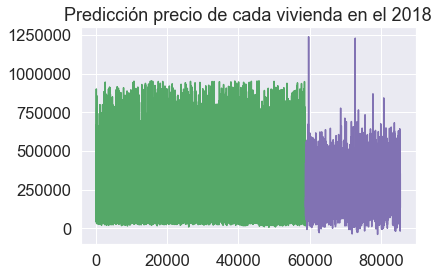

In [9]:
xt = x[:,-1].reshape( len(x[:,-1]), 1 )       # x= fecha (convertido en un array)
yt = y.reshape( len(y), 1 )  # y= IMPTOTAL (en un array)
t = t[:,-1].reshape( len(t[:,-1]), 1 )  #t= fecha predicciones

pyplot.title( "Predicción precio de cada vivienda en el 2018")
print("R-squared:", linear_regressor.score(x, y))
plot1 = pyplot.plot( xt, yt, c='g' )
plot2 = pyplot.plot( t, predictions, c='m' )

#PREDICCIÓN DEL IMPORTE DE CADA VIVIENDA

In [10]:
actual= test['IMPTOTAL']
forecast= test['BSpreu']
# Accuracy metrics
def metricas(forecast, actual):
    actual_min= actual.min()
    actual_max= actual.max()
    forecast_min= forecast.min()
    forecast_max= forecast.max()
    mape = round(np.mean(np.abs(forecast - actual)/np.abs(actual)),2)  # MAPE
    rmse = round(np.mean((forecast - actual)**2)**.5,2)  # RMSE
    mean = round(np.mean(forecast),2)  # RMSE
    corr = test[['IMPTOTAL', 'BSpreu']].corr()
    cov = test[['IMPTOTAL', 'BSpreu']].cov()
    var1= round(actual.var(),2)
    var2= round(forecast.var(),2)
    std1= round(actual.std(),2)
    std2= round(forecast.std(),2)
    return({'forecast_min': forecast_min, 'forecast_max':forecast_max,
           'actual_min':actual_min, 'actual_max':actual_max,
            'MAPE':mape,'RMSE':rmse, 'Media de las predicciones':mean,
            'Correlación':corr,
             'Covarianza': cov,
           'Varianza_IMPTOTAL': var1, 'Varianza_BSpreu':var2,
           'SD_IMPTOTAL': std1, 'SD_BSpreu':std2})

metricas(forecast,actual)

{'forecast_min': -39238.30285454169,
 'forecast_max': 1239142.1186473127,
 'actual_min': 1800.0,
 'actual_max': 953873.17,
 'MAPE': 0.62,
 'RMSE': 115581.54,
 'Media de las predicciones': 224245.63,
 'Correlación':           IMPTOTAL  BSpreu
 IMPTOTAL     1.000   0.646
 BSpreu       0.646   1.000,
 'Covarianza':                 IMPTOTAL         BSpreu
 IMPTOTAL 22316921063.211 9037715539.744
 BSpreu    9037715539.744 8769397294.567,
 'Varianza_IMPTOTAL': 22316921063.21,
 'Varianza_BSpreu': 8769397294.57,
 'SD_IMPTOTAL': 149388.49,
 'SD_BSpreu': 93645.06}

In [11]:
#test.to_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos - copia - Marta\predicciones2018_viviendas.csv',
            #sep=';', decimal=',', encoding="latin1", index=False)

In [12]:
labelencoder = LabelEncoder()
tablin['Provincia']= tablin['Provincia_x']
tablin['Provincia_x'] = labelencoder.fit_transform(tablin['Provincia_x'])
tablin['Index']= tablin.index

In [13]:
tablin['Preciom2'] = tablin['IMPTOTAL']/tablin['SUPERF_ADOPTADA']  #cálculo del precio del m2

In [14]:
group= tablin.groupby(['Fecha']).transform('median')   #Media precio toda España
group=group.drop_duplicates()

In [15]:
tabla = group
train = tabla.loc[~tabla['Fecha_num'].isin(['52','53','54','55'])] 
test= tabla.loc[tabla['Fecha_num'].isin(['52','53','54','55'])] 
train=train.sort_values(by=['Index'])
test= test.sort_values(by=['Index'])

In [16]:
#REGRESIÓN LINEAL PARA PREDECIR EL PRECIO DE TODAS LAS VIVIENDAS PARA EL AÑO QUE VIENE
# ESE MODELO ES UN TIME SERIES, COMO EL ARIMA, PERO CON REGRESIÓN LINEAL 

linear_regressor = linear_model.LinearRegression()

x = np.asarray(train.loc[:,['EDIF_FECHA_CONSTRUCCION', 'EDIF_CALIDAD_CONSTRU_COD',
       'EDIF_EST_CONSERVACION_COD', 'EDIF_PLANTA_SOBRE_RASANTE','VIV_ORIENTACION_COD', 'VIV_SUPERF_TERRAZA',
        'VIV_DISTR_NUM_DORMITORIOS', 'VIV_DISTR_NUM_ASEOS','VIV_INST_COCINA_EQUIPADA', 'VIV_INST_ARMARIOS_EMPOTR',
       'VIV_INST_PUERTA_SEGUR', 'VIV_INST_SISTEMA_ALARMA','VIV_INST_CIRCUITO_SEGUR', 
        'VIV_INST_AIRE_ACOND','VIV_INST_COMU_PISCINA', 'VIV_INST_COMU_OTRAS_DEPORT',
       'SUPERF_ADOPTADA','Hipotecas_log', 'Tasa desempleo_log', 'UBICACION_MUNICIPIO_DESC_Nivel medio',
        'UBICACION_MUNICIPIO_DESC_Por debajo del nivel medio','UBICACION_MUNICIPIO_DESC_Por encima del nivel medio',
    'UBICACION_ZONA_COD_DEB', 'UBICACION_ZONA_COD_ENC','UBICACION_ZONA_COD_MED', 'UBICACION_INMUEBLE_COD_DEB',
    'UBICACION_INMUEBLE_COD_ENC', 'UBICACION_INMUEBLE_COD_MED', 'change','Municipio', 'Index','Fecha_num']])
y = np.asarray(train.loc[:,['Preciom2']])
t = np.asarray(test.loc[:,['EDIF_FECHA_CONSTRUCCION', 'EDIF_CALIDAD_CONSTRU_COD',
       'EDIF_EST_CONSERVACION_COD', 'EDIF_PLANTA_SOBRE_RASANTE','VIV_ORIENTACION_COD', 'VIV_SUPERF_TERRAZA',
        'VIV_DISTR_NUM_DORMITORIOS', 'VIV_DISTR_NUM_ASEOS','VIV_INST_COCINA_EQUIPADA', 'VIV_INST_ARMARIOS_EMPOTR',
       'VIV_INST_PUERTA_SEGUR', 'VIV_INST_SISTEMA_ALARMA','VIV_INST_CIRCUITO_SEGUR', 
        'VIV_INST_AIRE_ACOND','VIV_INST_COMU_PISCINA', 'VIV_INST_COMU_OTRAS_DEPORT',
       'SUPERF_ADOPTADA','Hipotecas_log', 'Tasa desempleo_log','UBICACION_MUNICIPIO_DESC_Nivel medio',
        'UBICACION_MUNICIPIO_DESC_Por debajo del nivel medio','UBICACION_MUNICIPIO_DESC_Por encima del nivel medio',
    'UBICACION_ZONA_COD_DEB', 'UBICACION_ZONA_COD_ENC','UBICACION_ZONA_COD_MED', 'UBICACION_INMUEBLE_COD_DEB',
    'UBICACION_INMUEBLE_COD_ENC', 'UBICACION_INMUEBLE_COD_MED', 'change','Municipio', 'Index','Fecha_num']])
    
linear_regressor.fit(x,y)
    
predictions = linear_regressor.predict(t)    # ahora hace predicciones para el año 2018
test['BSpreu'] = predictions
#PREDICCIÓN PRECIO M2 MEDIO

In [17]:
test.loc[:, ['BSpreu', 'Preciom2']]

,BSpreu,Preciom2
58821,1275.188,1436.635
64939,1298.319,1428.258
75185,1469.593,1455.912
81360,1325.144,1365.385


R-squared: 1.0


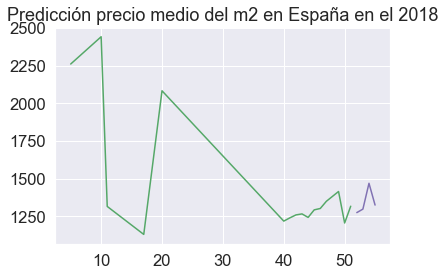

In [18]:
xt = x[:,-1].reshape( len(x[:,-1]), 1 )       # x= fecha (convertido en un array)
yt = y.reshape( len(y), 1 )  # y= IMPTOTAL (en un array)
t = t[:,-1].reshape( len(t[:,-1]), 1 )  #t= fecha predicciones

pyplot.title( "Predicción precio medio del m2 en España en el 2018")
print("R-squared:", linear_regressor.score(x, y))
plot1 = pyplot.plot( xt, yt, c='g' )
plot2 = pyplot.plot( t, predictions, c='m' )

In [19]:
actual= test['IMPTOTAL']
forecast= test['BSpreu']
# Accuracy metrics
def metricas(forecast, actual):
    actual_min= actual.min()
    actual_max= actual.max()
    forecast_min= forecast.min()
    forecast_max= forecast.max()
    mape = round(np.mean(np.abs(forecast - actual)/np.abs(actual)),2)  # MAPE
    rmse = round(np.mean((forecast - actual)**2)**.5,2)  # RMSE
    mean = round(np.mean(forecast),2)  # RMSE
    corr = test[['IMPTOTAL', 'BSpreu']].corr()
    cov = test[['IMPTOTAL', 'BSpreu']].cov()
    var1= round(actual.var(),2)
    var2= round(forecast.var(),2)
    std1= round(actual.std(),2)
    std2= round(forecast.std(),2)
    return({'forecast_min': forecast_min, 'forecast_max':forecast_max,
           'actual_min':actual_min, 'actual_max':actual_max,
            'MAPE':mape,'RMSE':rmse, 'Media de las predicciones':mean,
            'Correlación':corr,
             'Covarianza': cov,
           'Varianza_IMPTOTAL': var1, 'Varianza_BSpreu':var2,
           'SD_IMPTOTAL': std1, 'SD_BSpreu':std2})

metricas(forecast,actual)

{'forecast_min': 1275.1878329288636,
 'forecast_max': 1469.593337946447,
 'actual_min': 159880.33500000002,
 'actual_max': 162575.52,
 'MAPE': 0.99,
 'RMSE': 159695.45,
 'Media de las predicciones': 1342.06,
 'Correlación':           IMPTOTAL  BSpreu
 IMPTOTAL     1.000  -0.065
 BSpreu      -0.065   1.000,
 'Covarianza':             IMPTOTAL    BSpreu
 IMPTOTAL 1278483.862 -6394.435
 BSpreu     -6394.435  7645.367,
 'Varianza_IMPTOTAL': 1278483.86,
 'Varianza_BSpreu': 7645.37,
 'SD_IMPTOTAL': 1130.7,
 'SD_BSpreu': 87.44}

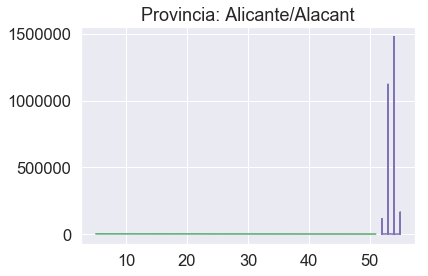

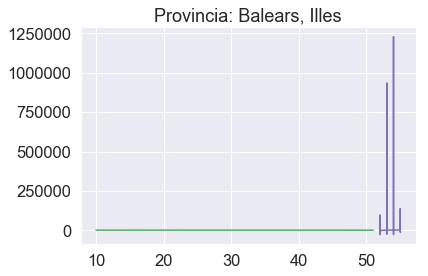

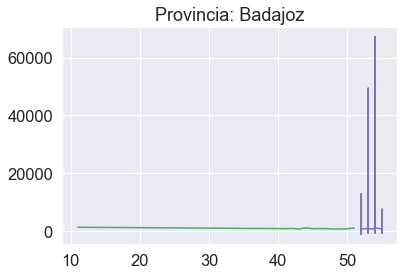

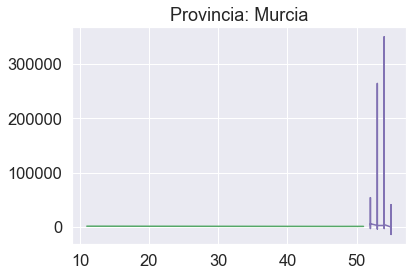

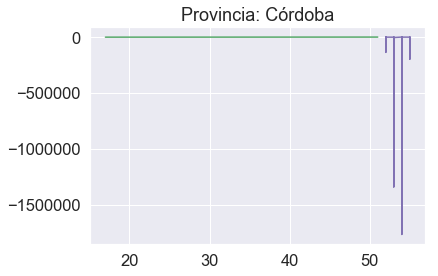

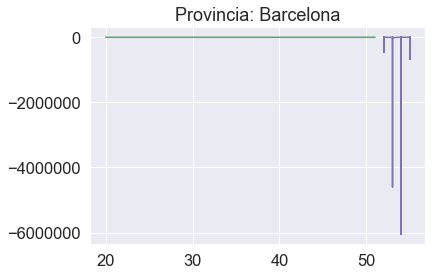

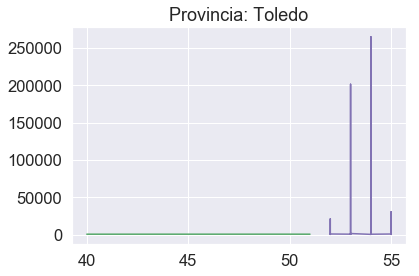

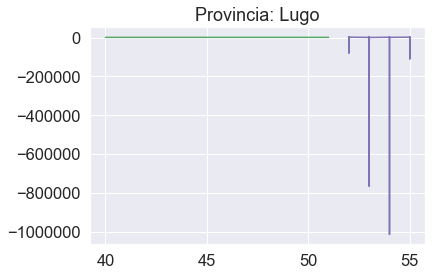

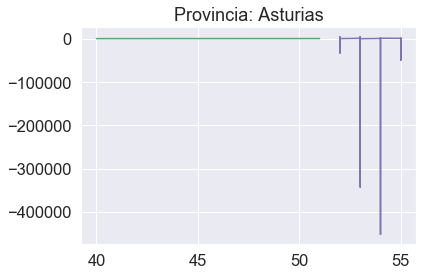

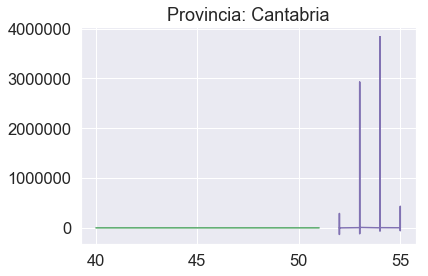

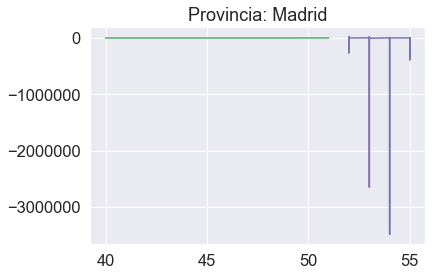

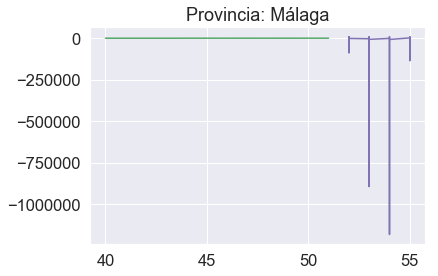

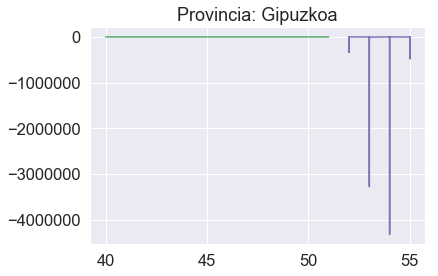

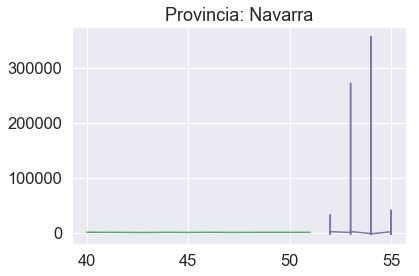

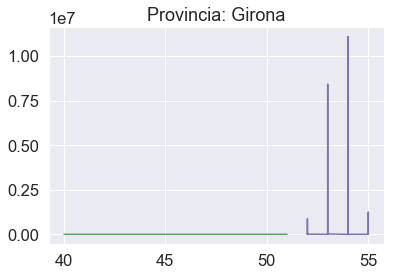

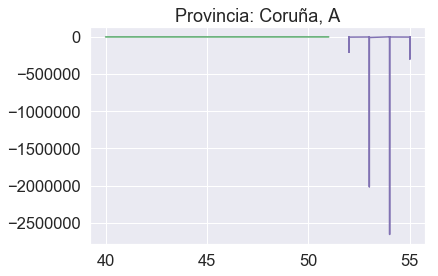

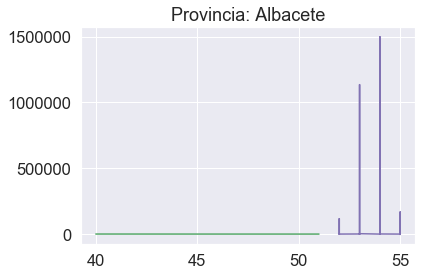

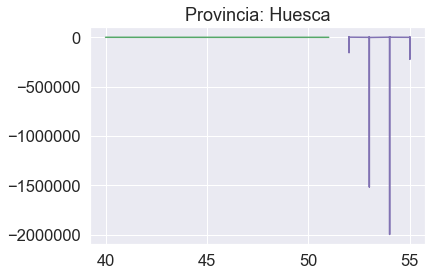

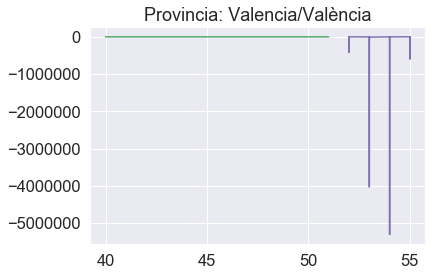

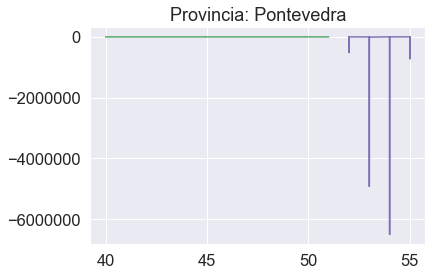

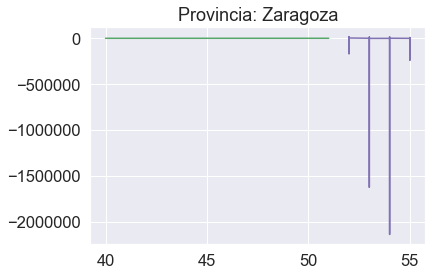

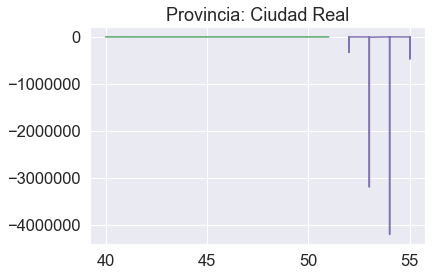

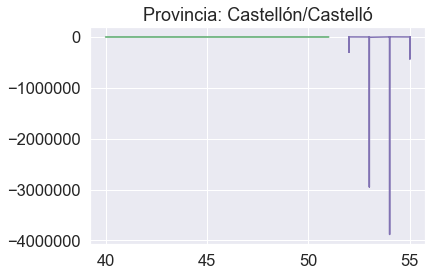

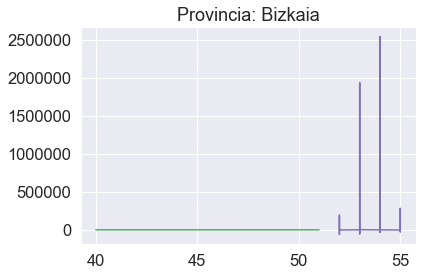

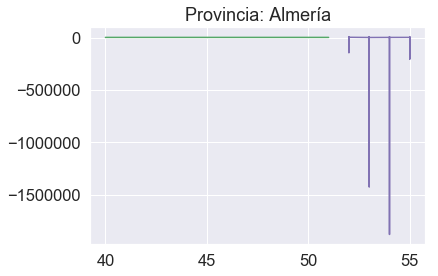

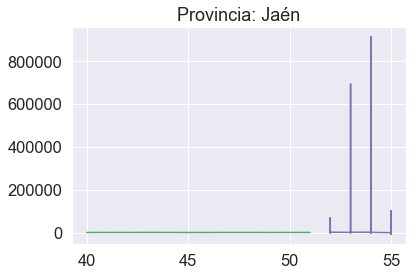

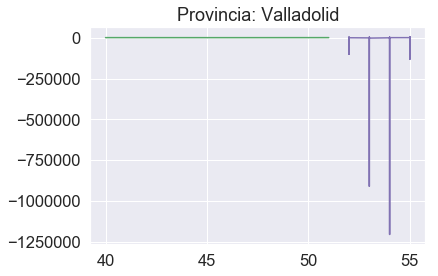

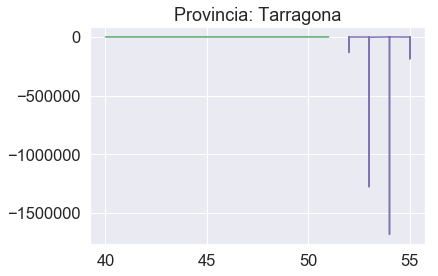

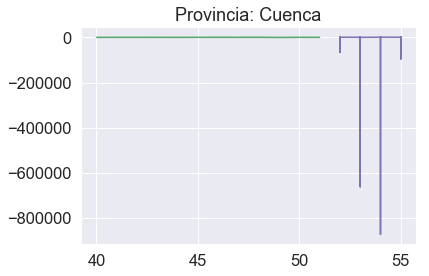

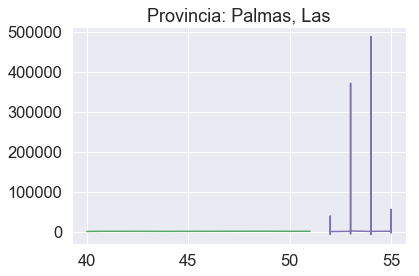

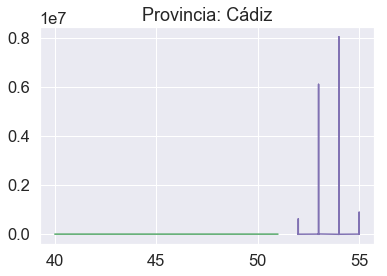

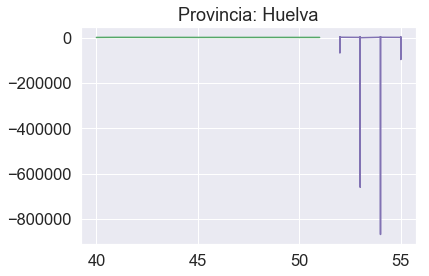

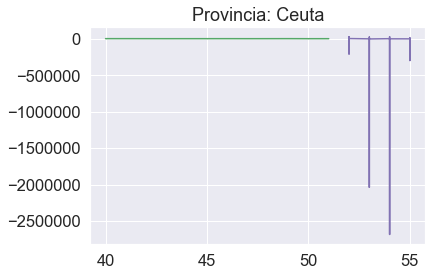

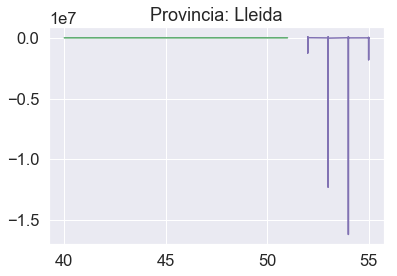

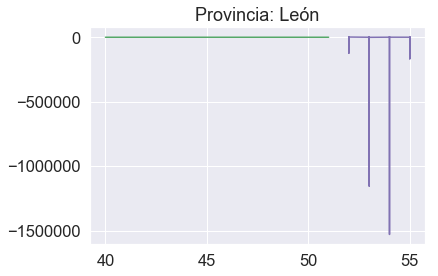

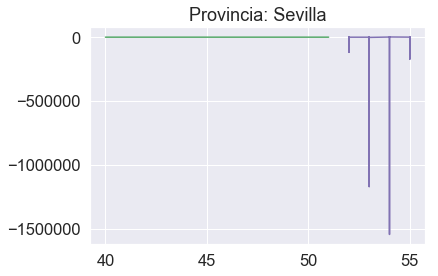

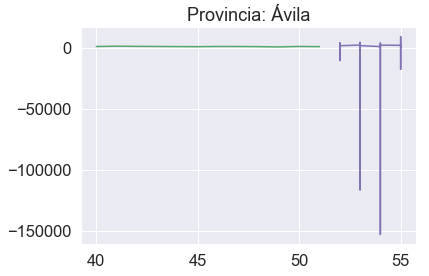

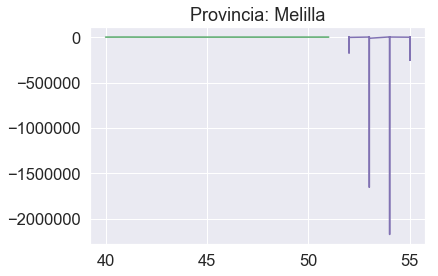

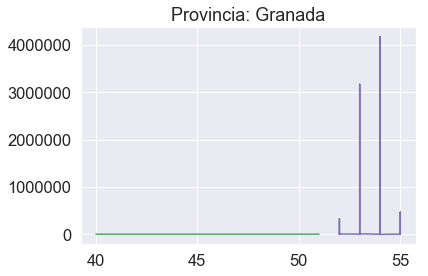

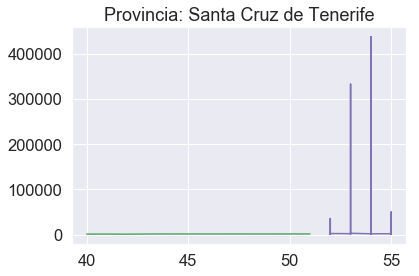

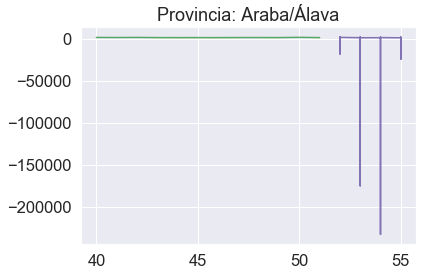

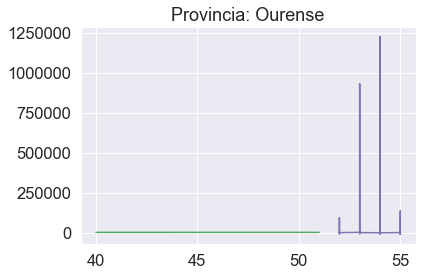

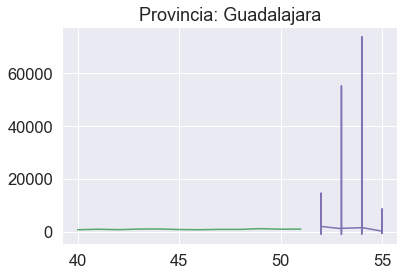

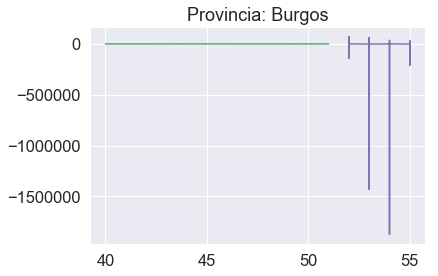

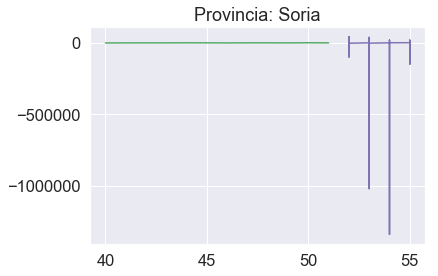

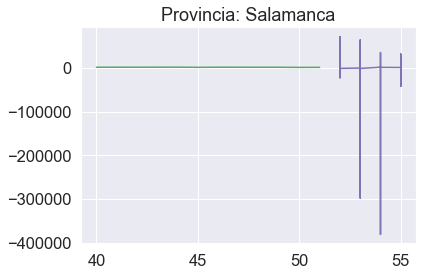

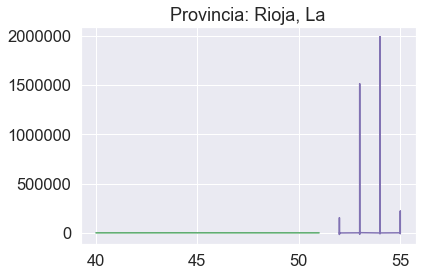

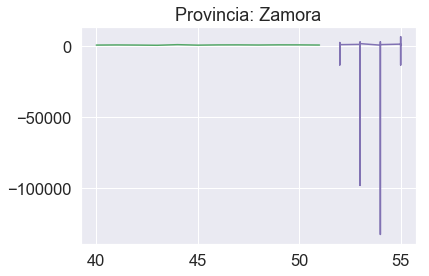

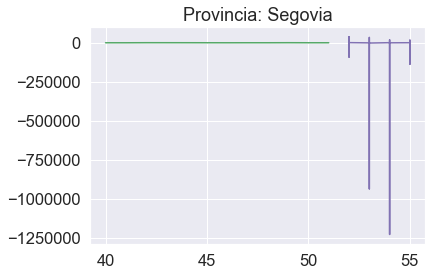

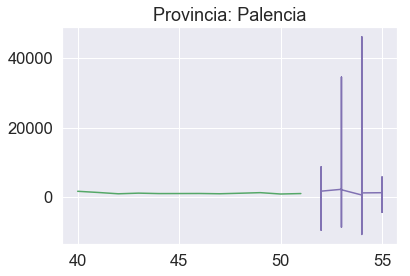

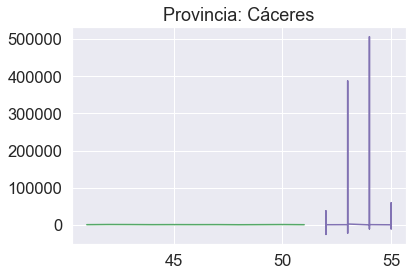

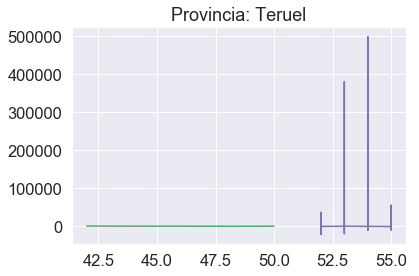

In [187]:
# ESE MODELO ES UN TIME SERIES, COMO EL ARIMA, PERO CON REGRESIÓN LINEAL 

linear_regressor = linear_model.LinearRegression()
tablon = tablin

for prov in tablon.Provincia.unique():

    train = tablon.loc[~tablon['Fecha_num'].isin(['52','53','54','55'])] 
    test= tablon.loc[tablon['Fecha_num'].isin(['52','53','54','55'])] 
    train=train.sort_values(by=['Index'])
    test= test.sort_values(by=['Index'])
    
    grou = train[train.Provincia==prov]
    grou['Indice_Fecha'] = range(len(grou))
    group= grou.groupby(['Fecha']).transform('median')
    
    x = np.asarray(group.loc[:,['EDIF_FECHA_CONSTRUCCION', 'EDIF_CALIDAD_CONSTRU_COD',
       'EDIF_EST_CONSERVACION_COD', 'EDIF_PLANTA_SOBRE_RASANTE','VIV_ORIENTACION_COD', 'VIV_SUPERF_TERRAZA',
        'VIV_DISTR_NUM_DORMITORIOS', 'VIV_DISTR_NUM_ASEOS','VIV_INST_COCINA_EQUIPADA', 'VIV_INST_ARMARIOS_EMPOTR',
       'VIV_INST_PUERTA_SEGUR', 'VIV_INST_SISTEMA_ALARMA','VIV_INST_CIRCUITO_SEGUR', 
        'VIV_INST_AIRE_ACOND','VIV_INST_COMU_PISCINA', 'VIV_INST_COMU_OTRAS_DEPORT',
       'SUPERF_ADOPTADA','Hipotecas_log', 'Tasa desempleo_log', 'UBICACION_MUNICIPIO_DESC_Nivel medio',
        'UBICACION_MUNICIPIO_DESC_Por debajo del nivel medio','UBICACION_MUNICIPIO_DESC_Por encima del nivel medio',
    'UBICACION_ZONA_COD_DEB', 'UBICACION_ZONA_COD_ENC','UBICACION_ZONA_COD_MED', 'UBICACION_INMUEBLE_COD_DEB',
    'UBICACION_INMUEBLE_COD_ENC', 'UBICACION_INMUEBLE_COD_MED', 'change','Municipio', 'Index','Fecha_num']])
    y = np.asarray(group.loc[:,['Preciom2']])
    t = np.asarray(test.loc[:,['EDIF_FECHA_CONSTRUCCION', 'EDIF_CALIDAD_CONSTRU_COD',
       'EDIF_EST_CONSERVACION_COD', 'EDIF_PLANTA_SOBRE_RASANTE','VIV_ORIENTACION_COD', 'VIV_SUPERF_TERRAZA',
        'VIV_DISTR_NUM_DORMITORIOS', 'VIV_DISTR_NUM_ASEOS','VIV_INST_COCINA_EQUIPADA', 'VIV_INST_ARMARIOS_EMPOTR',
       'VIV_INST_PUERTA_SEGUR', 'VIV_INST_SISTEMA_ALARMA','VIV_INST_CIRCUITO_SEGUR', 
        'VIV_INST_AIRE_ACOND','VIV_INST_COMU_PISCINA', 'VIV_INST_COMU_OTRAS_DEPORT',
       'SUPERF_ADOPTADA','Hipotecas_log', 'Tasa desempleo_log','UBICACION_MUNICIPIO_DESC_Nivel medio',
        'UBICACION_MUNICIPIO_DESC_Por debajo del nivel medio','UBICACION_MUNICIPIO_DESC_Por encima del nivel medio',
    'UBICACION_ZONA_COD_DEB', 'UBICACION_ZONA_COD_ENC','UBICACION_ZONA_COD_MED', 'UBICACION_INMUEBLE_COD_DEB',
    'UBICACION_INMUEBLE_COD_ENC', 'UBICACION_INMUEBLE_COD_MED', 'change','Municipio', 'Index','Fecha_num']])
    
    xt = x[:,-1].reshape( len(x[:,-1]), 1 )       # x= fecha (convertido en un array)
    yt = y.reshape( len(y), 1 )  # y= Preciom2 (en un array)
    tt = t[:,-1].reshape( len(t[:,-1]), 1 )  #t= fecha predicciones
    
    linear_regressor.fit(x,yt)
    predictions = linear_regressor.predict(t)    # ahora hace predicciones para el año 2018
    
    
    pyplot.title("Provincia: %s" % prov )
    plot1 = pyplot.plot(xt, yt, c='g' )
    plot2 = pyplot.plot(tt, predictions, c='m' )
    
    list_predictions = [item for sublist in predictions for item in sublist]
    test['BSpreu'] = list_predictions
    

    pyplot.show()
    

In [ ]:
#Parece ser que los municipios disponibles cambian en función de la fecha

In [173]:
test

,EDIF_FECHA_CONSTRUCCION,EDIF_CALIDAD_CONSTRU_COD,EDIF_EST_CONSERVACION_COD,EDIF_PLANTA_SOBRE_RASANTE,VIV_ORIENTACION_COD,VIV_SUPERF_TERRAZA,VIV_DISTR_NUM_DORMITORIOS,VIV_DISTR_NUM_ASEOS,VIV_INST_COCINA_EQUIPADA,VIV_INST_ARMARIOS_EMPOTR,...,UBICACION_MUNICIPIO_DESC_Por encima del nivel medio,UBICACION_ZONA_COD_DEB,UBICACION_ZONA_COD_ENC,UBICACION_ZONA_COD_MED,UBICACION_INMUEBLE_COD_DEB,UBICACION_INMUEBLE_COD_ENC,UBICACION_INMUEBLE_COD_MED,Provincia,Preciom2,BSpreu
58821,165,3.0,0.0,1.000,2.0,2.000,3.000,1.000,1,0,...,0,0,0,1,0,0,1,Barcelona,1899.419,487.214
58822,172,3.0,6.0,7.000,2.0,9.120,3.000,1.000,1,1,...,0,0,0,1,0,0,1,Gipuzkoa,1633.870,49.002
58823,206,3.0,2.0,3.000,2.0,0.000,2.000,2.000,1,1,...,0,0,0,1,0,0,1,Alicante/Alacant,634.570,764.456
58824,175,4.0,6.0,6.000,2.0,0.000,4.000,2.000,1,0,...,0,0,0,1,0,0,1,Alicante/Alacant,342.680,427.107
58825,218,3.0,6.0,2.000,2.0,0.000,4.000,3.000,1,1,...,0,0,0,1,0,0,1,Zaragoza,1186.660,39.986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85401,215,3.0,2.0,4.000,2.0,0.000,3.000,2.000,0,0,...,0,0,0,1,0,0,1,Gipuzkoa,459.120,-67.732
85402,185,3.0,2.0,0.000,2.0,0.000,2.000,1.000,1,0,...,1,0,0,1,0,0,1,Girona,2366.130,150.798
85403,218,3.0,2.0,2.000,2.0,0.000,3.000,3.000,0,1,...,0,0,0,1,0,0,1,Alicante/Alacant,1297.160,-84.384
85404,208,2.0,2.0,6.000,2.0,0.000,2.000,2.000,1,1,...,0,0,1,0,0,1,0,Zaragoza,3985.000,-579.767
